In [2]:
import sys
sys.path.append("../") # adding the path to read the utils file
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics, tree
from shap import plots, Explanation
import fasttreeshap
import time
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle
import lightgbm as lgb
from utils import *
import graphviz
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap
import glob

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
ds = pd.concat([pd.read_csv(csv_file, engine='pyarrow', index_col='id') for csv_file in glob.glob('../datasets/NFS-2023-TE/*.csv')], ignore_index=True)
ds.head()

,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,protocol,ip_version,vlan_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_first_seen_ms,src2dst_last_seen_ms,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_first_seen_ms,dst2src_last_seen_ms,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,label
0,-1,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1031,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,6,4,0,1499428835357,1499428835358,1,6,800,1499428835357,1499428835358,1,4,473,1499428835357,1499428835358,1,2,327,60,133.333333,109.302638,287,60,118.25,112.535550,287,66,163.5,137.885822,261,0,0.200000,0.447214,1,0,0.333333,0.57735,1,1,1.0,0.000000,1,2,0,0,0,5,2,0,1,1,0,0,0,3,1,0,1,1,0,0,0,2,1,0,0,BENIGN
1,-1,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1031,6,4,0,1499428835358,1499428835358,0,2,120,1499428835358,1499428835358,0,2,120,0,0,0,0,0,60,60.000000,0.000000,60,60,60.00,0.000000,60,0,0.0,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,0.000000,0,0,0,0,0,2,0,1,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,BENIGN
2,-1,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1032,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,6,4,0,1499428835374,1499428835375,1,7,2265,1499428835374,1499428835375,1,5,613,1499428835374,1499428835375,1,2,1652,60,323.571429,568.141372,1586,60,122.60,136.648454,367,66,826.0,1074.802307,1586,0,0.166667,0.408248,1,0,0.250000,0.50000,1,1,1.0,0.000000,1,2,0,0,0,6,2,0,1,1,0,0,0,4,1,0,1,1,0,0,0,2,1,0,0,BENIGN
3,-1,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1032,6,4,0,1499428835375,1499428835375,0,2,120,1499428835375,1499428835375,0,2,120,0,0,0,0,0,60,60.000000,0.000000,60,60,60.00,0.000000,60,0,0.0,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,0.000000,0,0,0,0,0,2,0,1,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,BENIGN
4,-1,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1033,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,6,4,0,1499428835416,1499428835417,1,8,3550,1499428835416,1499428835417,1,5,1852,1499428835416,1499428835417,1,3,1698,60,443.750000,706.926901,1606,60,370.40,690.726284,1606,60,566.0,871.226721,1572,0,0.142857,0.377964,1,0,0.250000,0.50000,1,0,0.5,0.707107,1,2,0,0,0,7,2,0,1,1,0,0,0,4,1,0,1,1,0,0,0,3,1,0,0,BENIGN


In [4]:
compute_ratio(ds,'label')

                            Ratio
label                            
BENIGN                      83.71
PortScan                     7.34
DoS Hulk                     5.03
DDoS                         3.03
FTP-Patator                  0.25
DoS GoldenEye                0.25
DoS slowloris                0.16
SSH-Patator                  0.09
DoS Slowhttptest             0.09
Bot                          0.02
Web Attack - Brute Force     0.00
Infiltration                 0.00
Web Attack - XSS             0.00
Web Attack - Sql Injection   0.00
Heartbleed                   0.00


In [5]:
ds = ds.drop(columns=['expiration_id','src_ip','src_mac','src_oui','src_port','dst_ip','dst_mac','dst_oui','dst_port','ip_version','vlan_id'])

In [6]:
sample_weights = ds.label.value_counts().to_dict()

In [7]:
sample_weights['BENIGN'] = 738
sample_weights['PortScan'] = 738
sample_weights['DoS Hulk'] = 738
sample_weights['DDoS'] = 738
sample_weights['FTP-Patator'] = 738
sample_weights['DoS GoldenEye'] = 738
sample_weights['DoS slowloris'] = 738
sample_weights['SSH-Patator'] = 738
sample_weights['DoS Slowhttptest'] = 738

In [8]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 16, 
    'n_estimators': 48,
    'max_depth': 6, 
    'n_jobs': -1, 
    'verbosity': 0,
    'num_class': 14
}

bst = lgb.LGBMClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy=sample_weights)
X_res, y_res = rus.fit_resample(ds.drop(columns=['label']), ds['label'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12,  stratify=y_res)

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [11]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    bst.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = bst.predict(X_res.iloc[train_index])
    y_predicted_test = bst.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [12]:
%time bst.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(max_depth=6, n_estimators=48, n_jobs=-1, num_class=14,
               num_leaves=16, objective='multiclass', verbosity=0)

In [13]:
%time y_predicted_train = bst.predict(X_train)
%time y_predicted_test = bst.predict(X_test)

CPU times: user 632 ms, sys: 4.44 ms, total: 637 ms
Wall time: 71.4 ms
CPU times: user 206 ms, sys: 820 µs, total: 206 ms
Wall time: 19.4 ms


In [14]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [15]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.431740,0.423127
1,PRECISION,0.394617,0.389394
2,RECALL,0.431740,0.423127
3,F1 SCORE,0.320065,0.310779


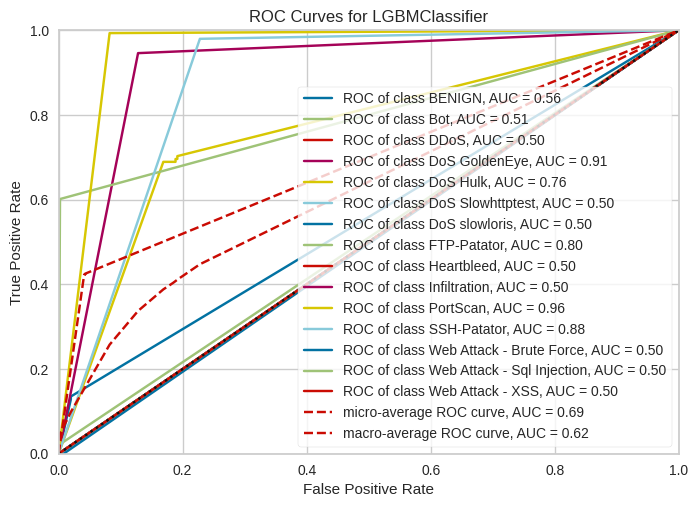

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [16]:


model = wrap(bst)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

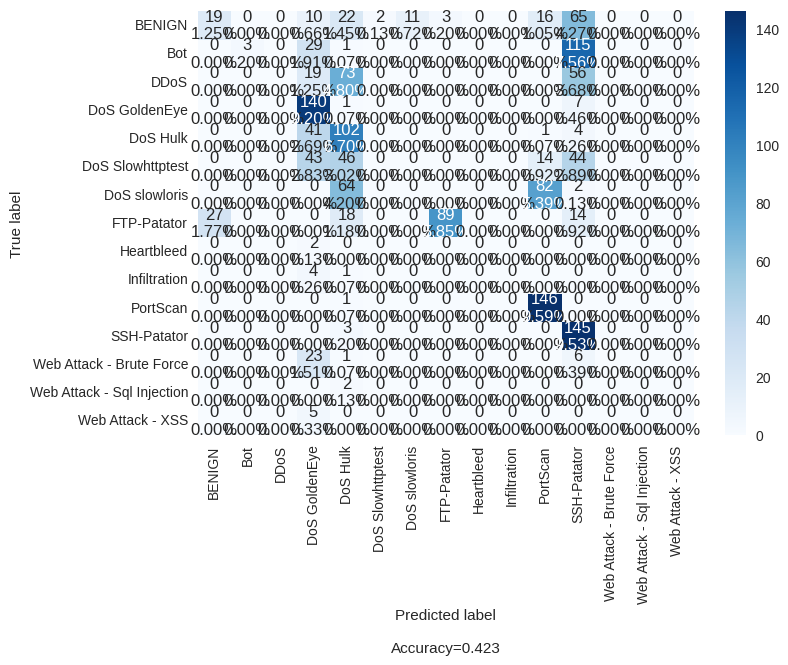

In [17]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(bst.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [18]:
# Create a plot for each tree in the model
for i in range(bst.n_estimators_):
    graph = lgb.create_tree_digraph(bst, tree_index=i, name='Tree {}'.format(i), show_info=['split_gain', 'internal_value', 'leaf_count'])
    graph.render(filename='tree_{}'.format(i), directory='lgb_data/tree', format='pdf')

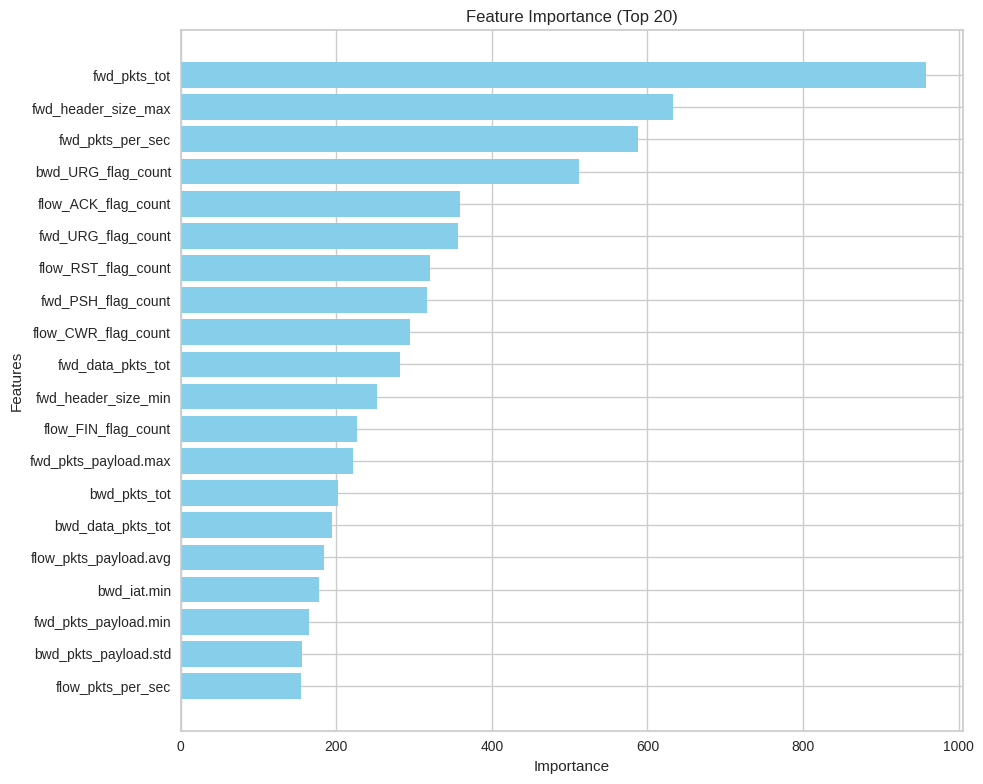

In [19]:
feature_importance = bst.feature_importances_
x_features_np = np.array(x_features)

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = x_features_np[sorted_indices][:20][::-1]  # Select only the first 20 features
sorted_importance = feature_importance[sorted_indices][:20][::-1]  # Select importance values for the first 20 features

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_importance)), sorted_features)  # Use yticks for feature names
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)')
plt.tight_layout()

# Show plot
plt.show()

In [20]:
%%time

if True:
    explainer = fasttreeshap.TreeExplainer(bst, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional")
    sv = explainer(X_train, check_additivity=False)

    with open('lgb_data/exp.pickle', 'wb') as handle:
        pickle.dump(sv, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("loading exp")
    with open('lgb_data/exp.pickle', 'rb') as handle:
        sv = pickle.load(handle)

  8%|==                  | 7354/91305 [01:29<16:55]       

## Background shap

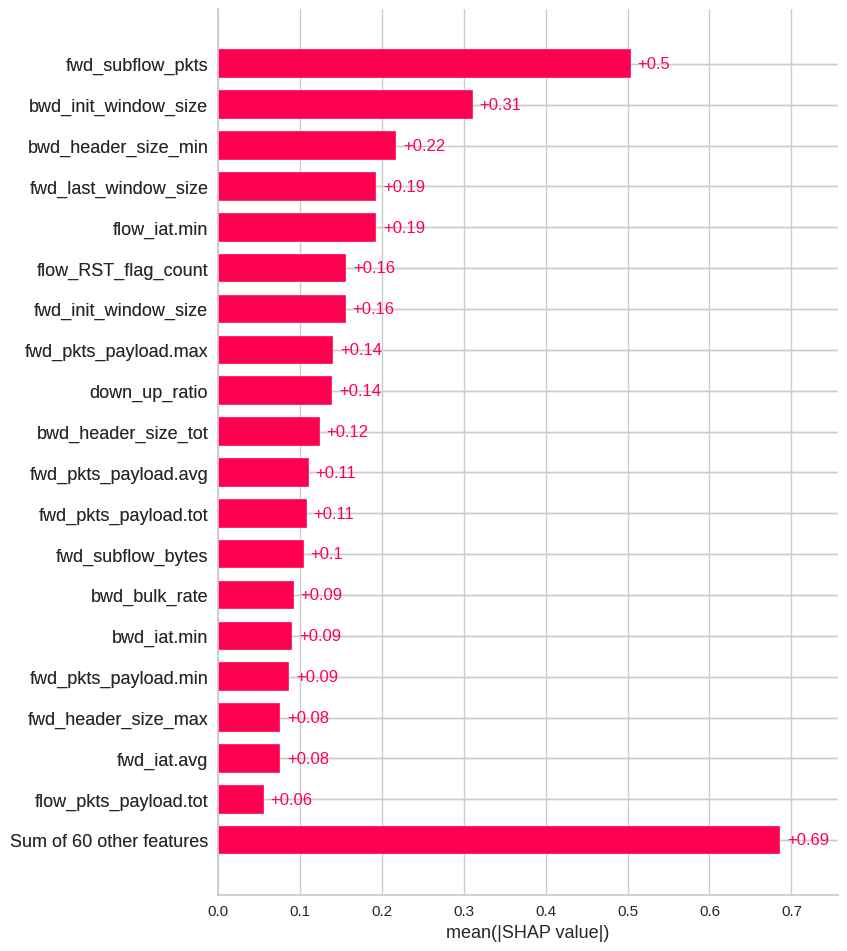

In [ ]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

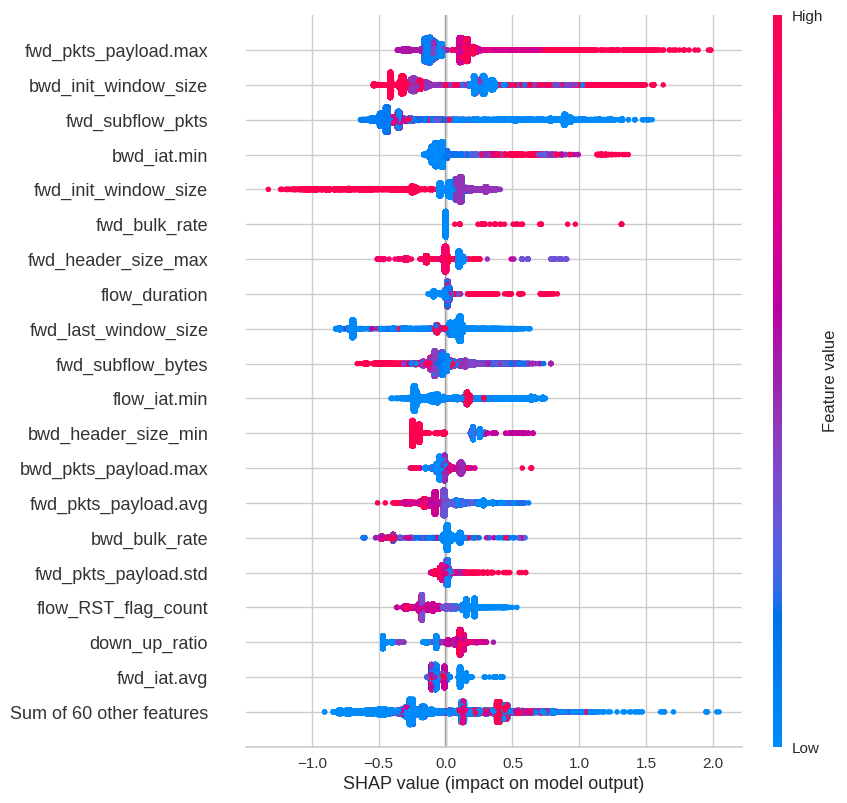

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

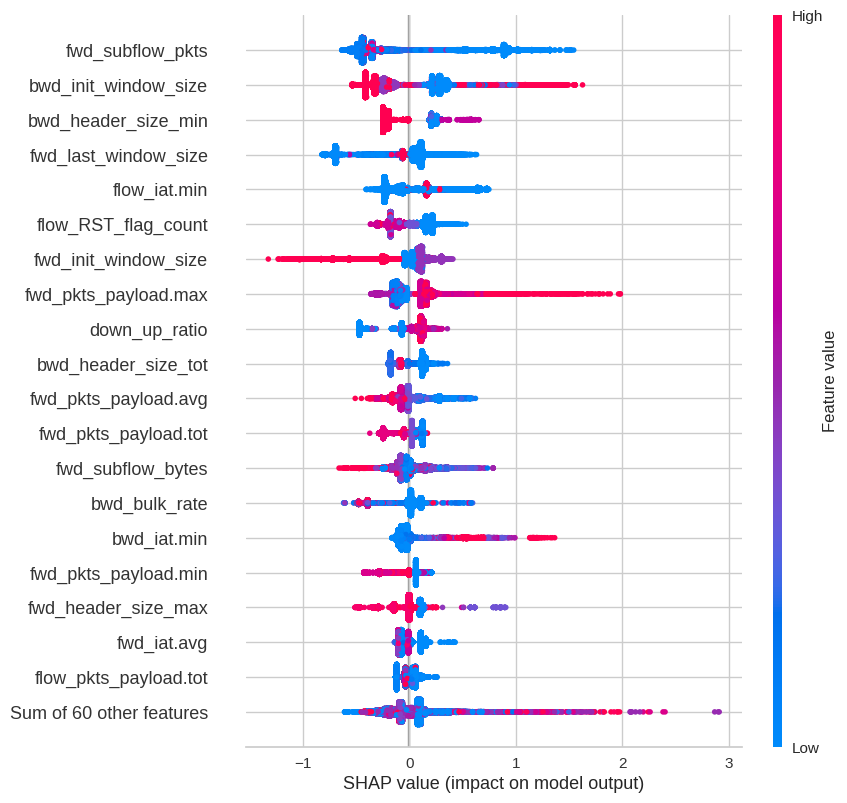

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bening shap

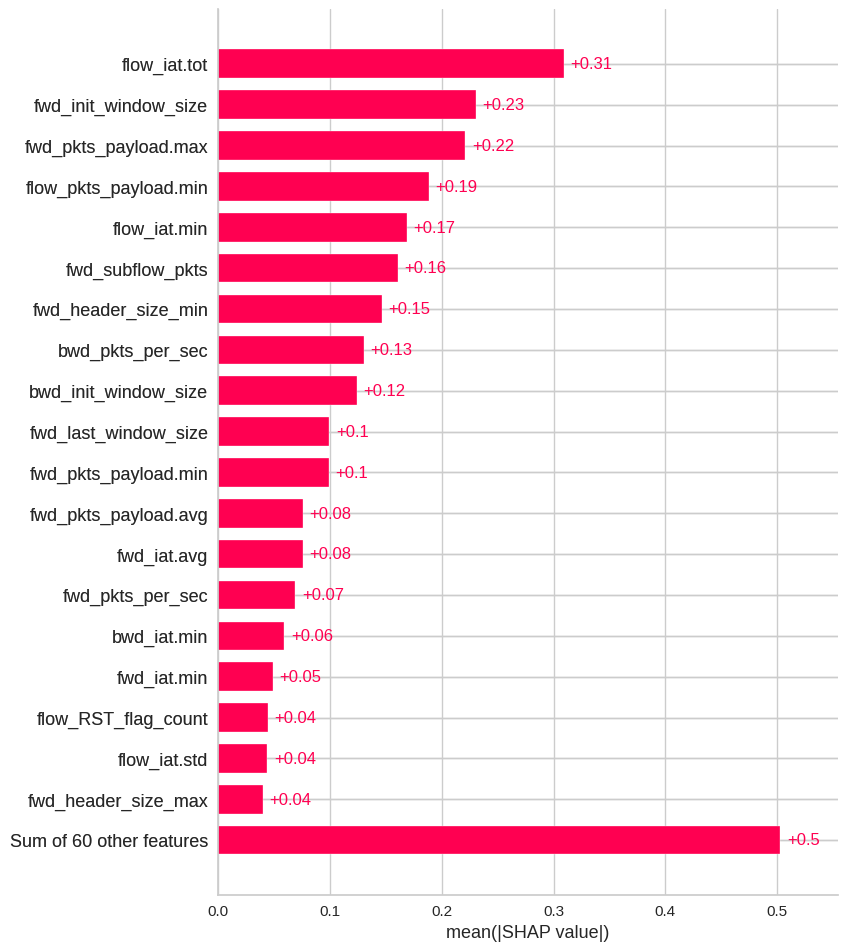

In [ ]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

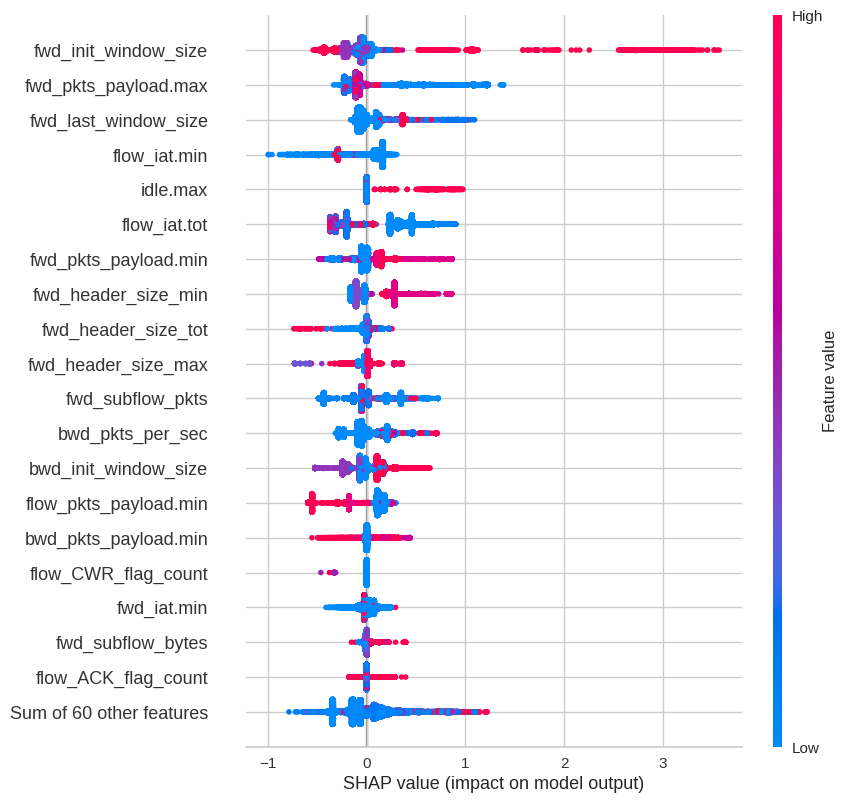

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

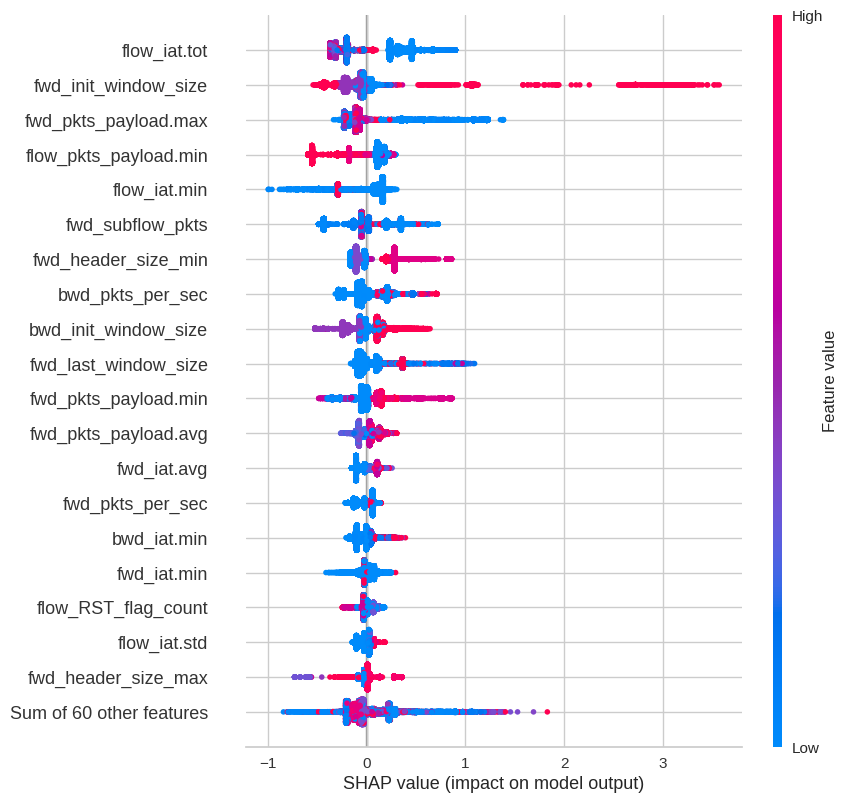

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce shap

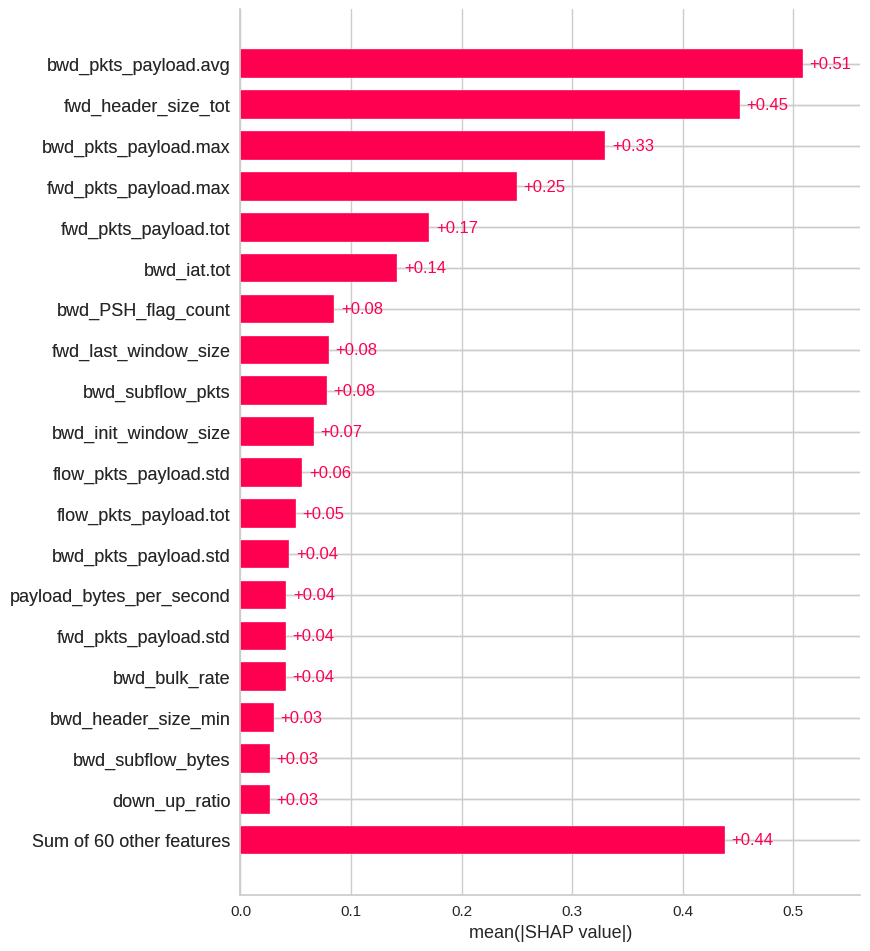

In [ ]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

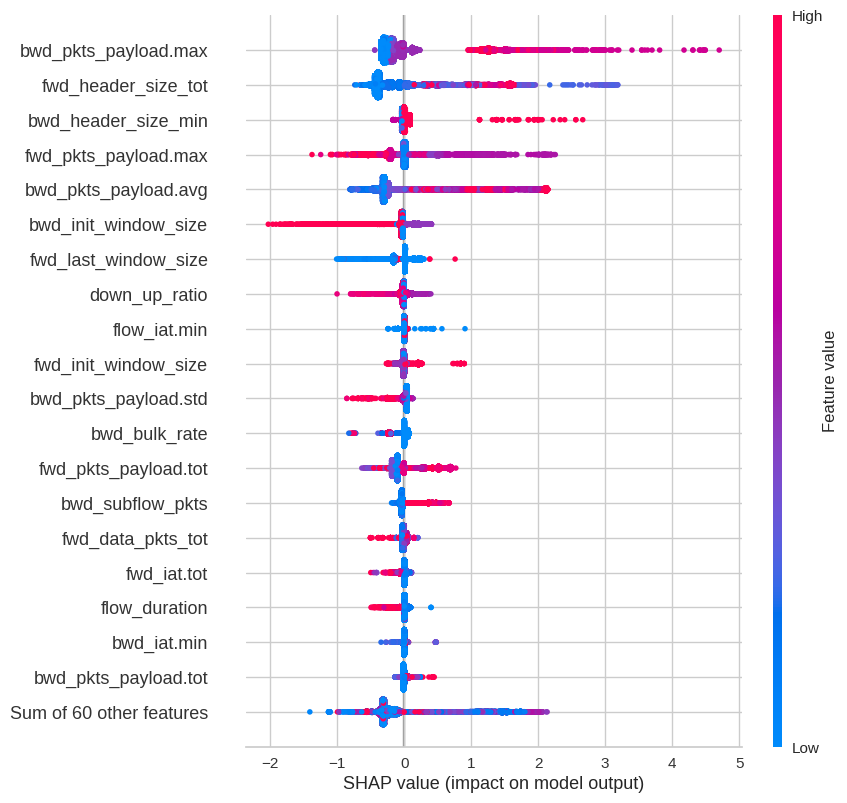

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

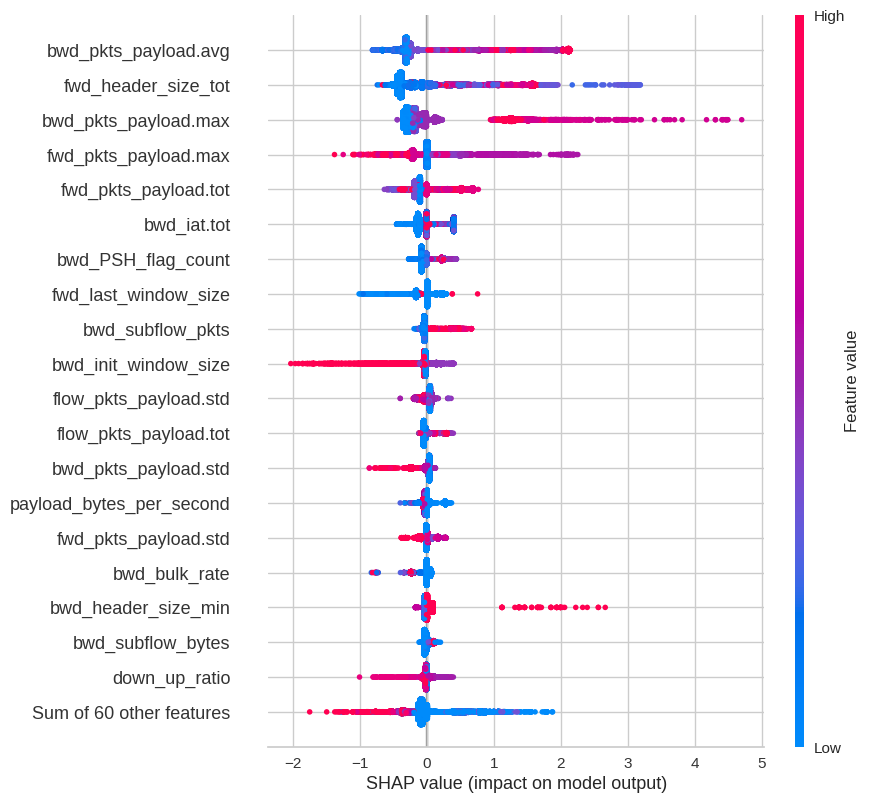

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce XML shap

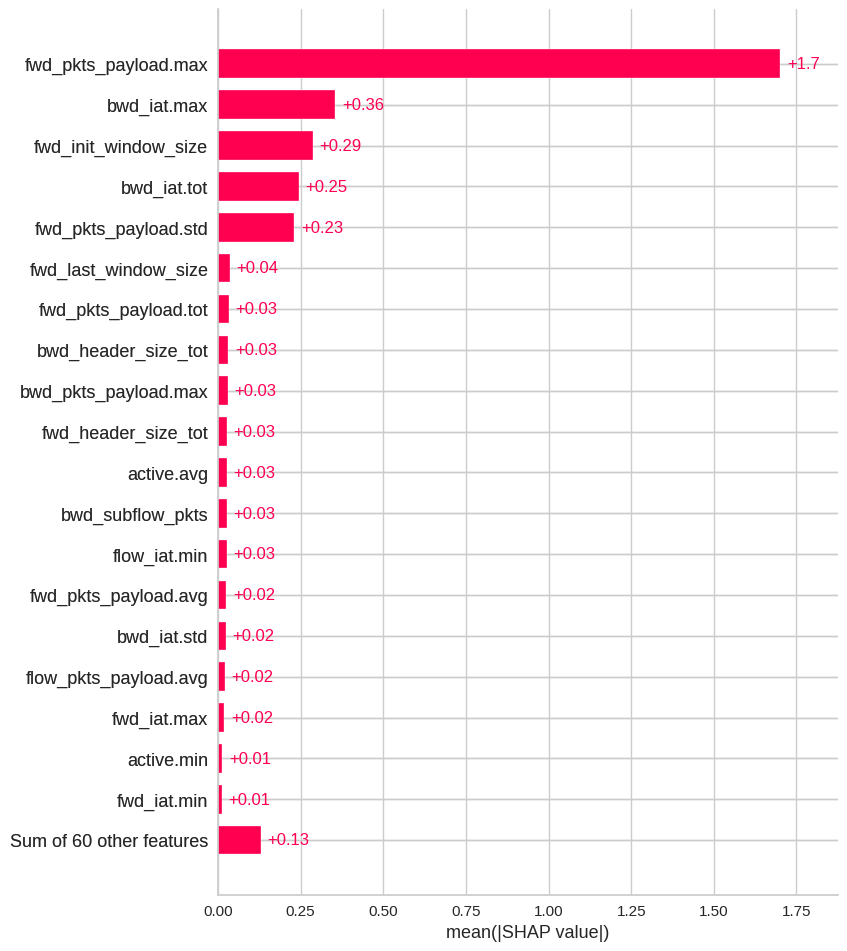

In [ ]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

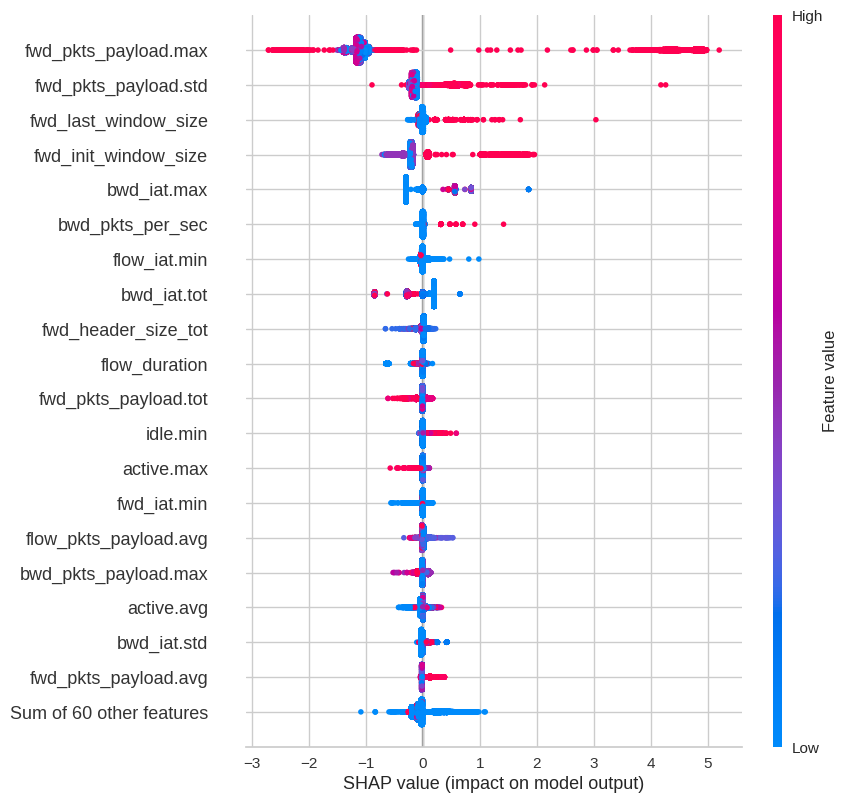

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

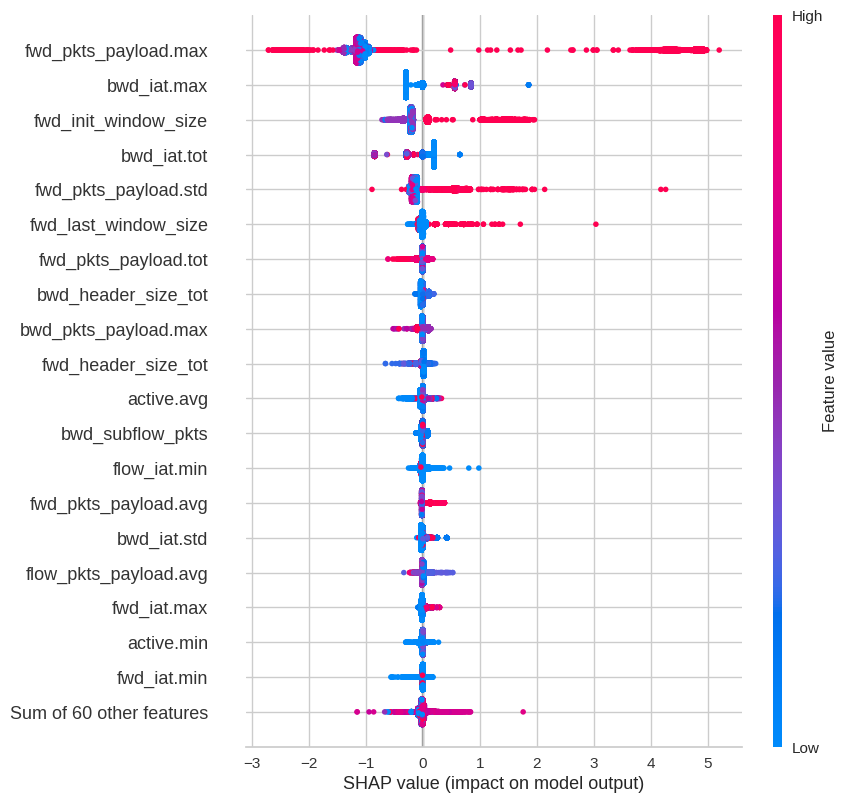

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Probing shap

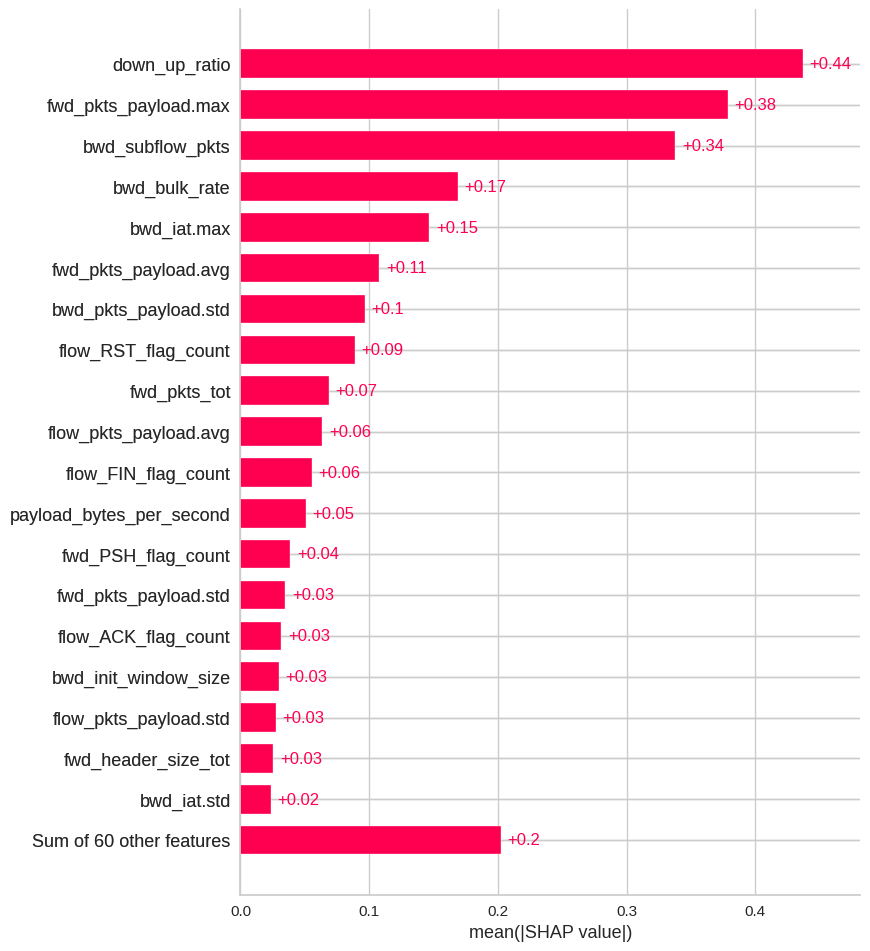

In [ ]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

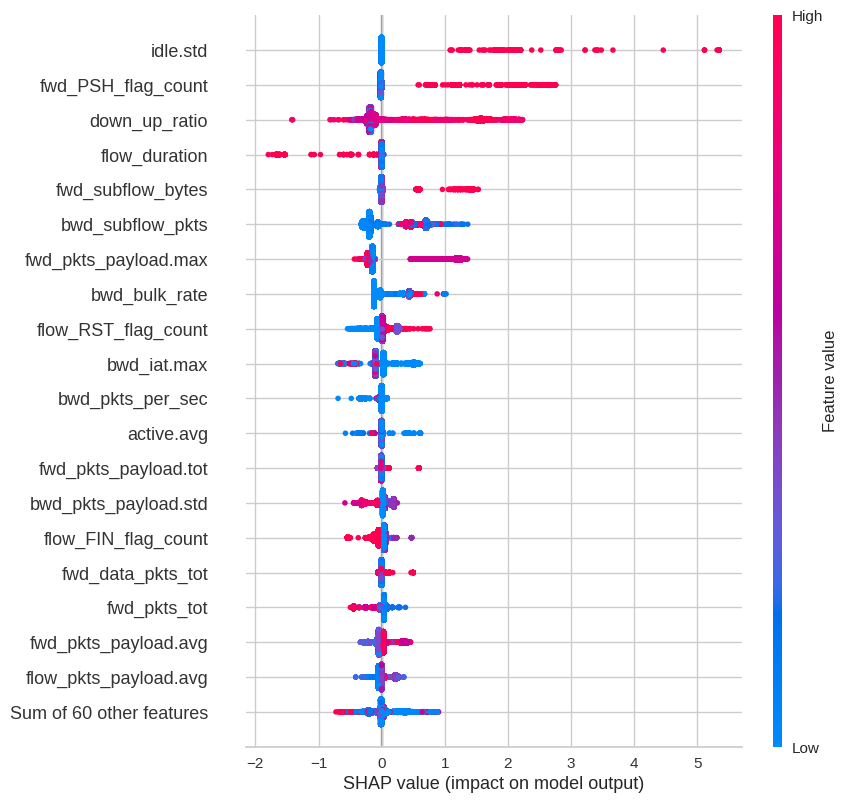

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

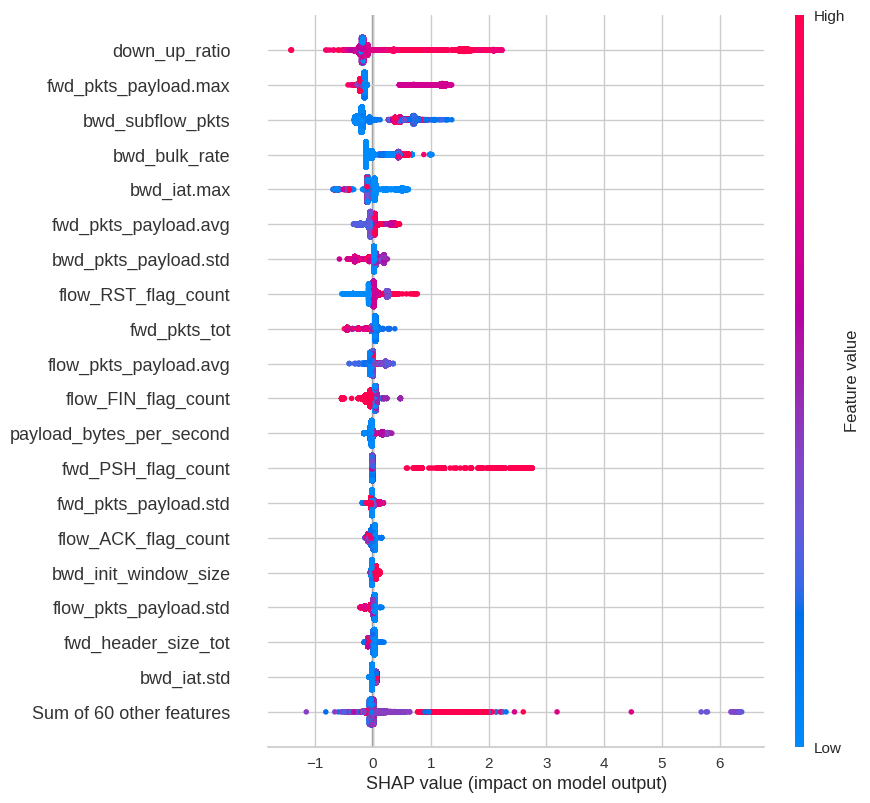

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Miner shap

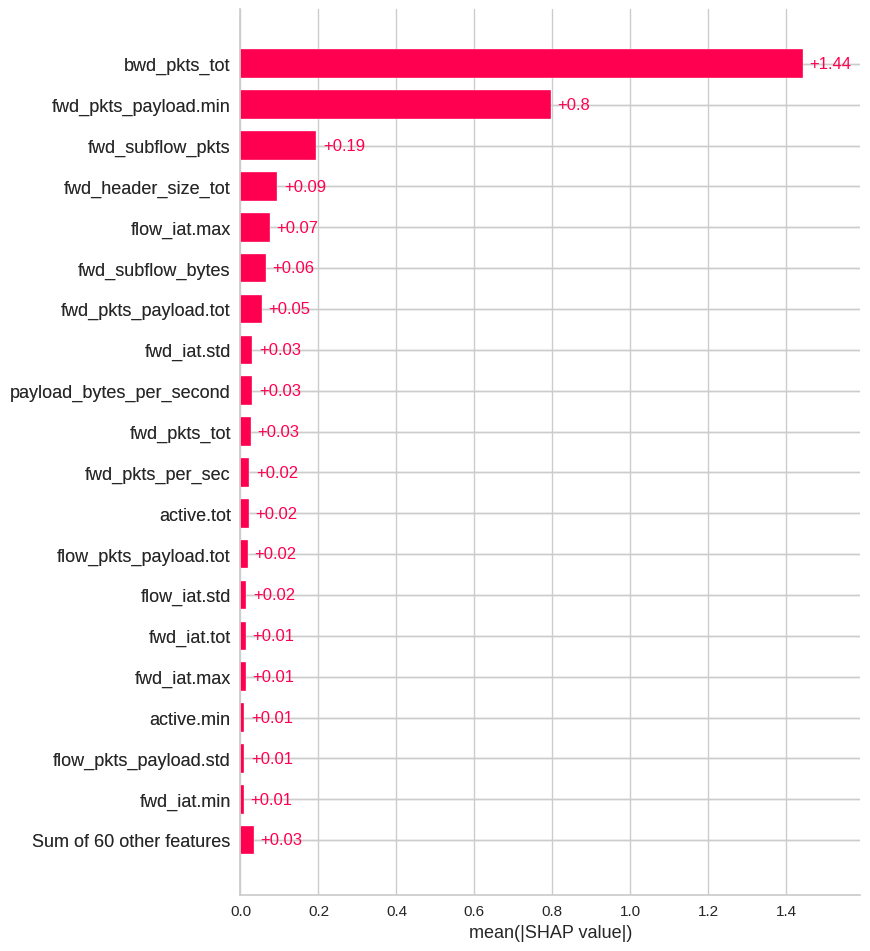

In [ ]:
exp = Explanation(sv.values[:,:,5], 
                  sv.base_values[:,5], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

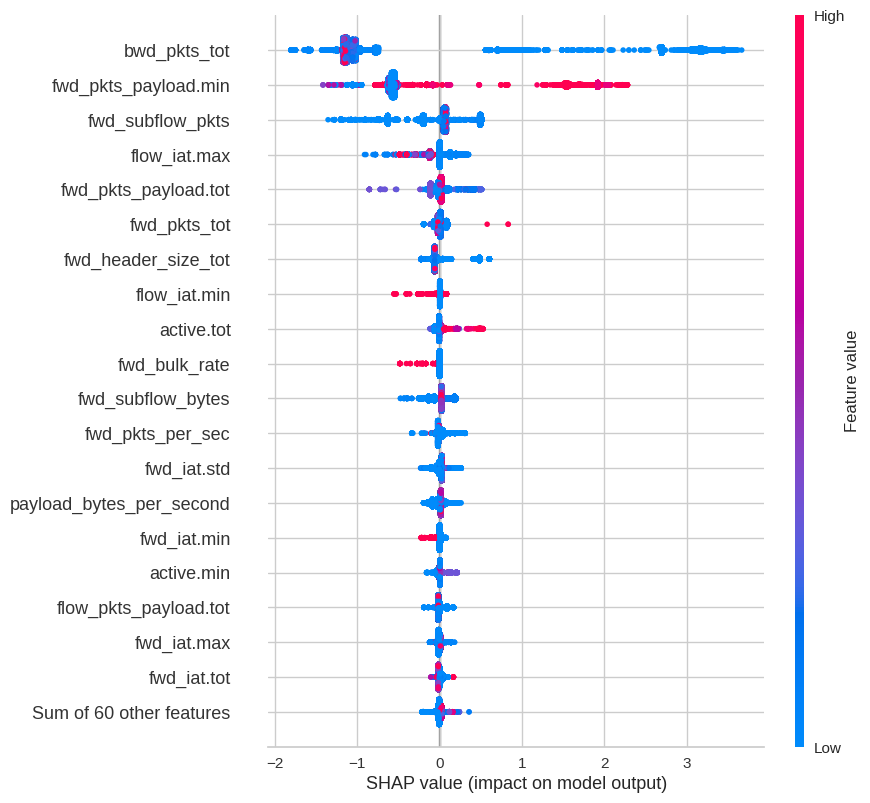

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

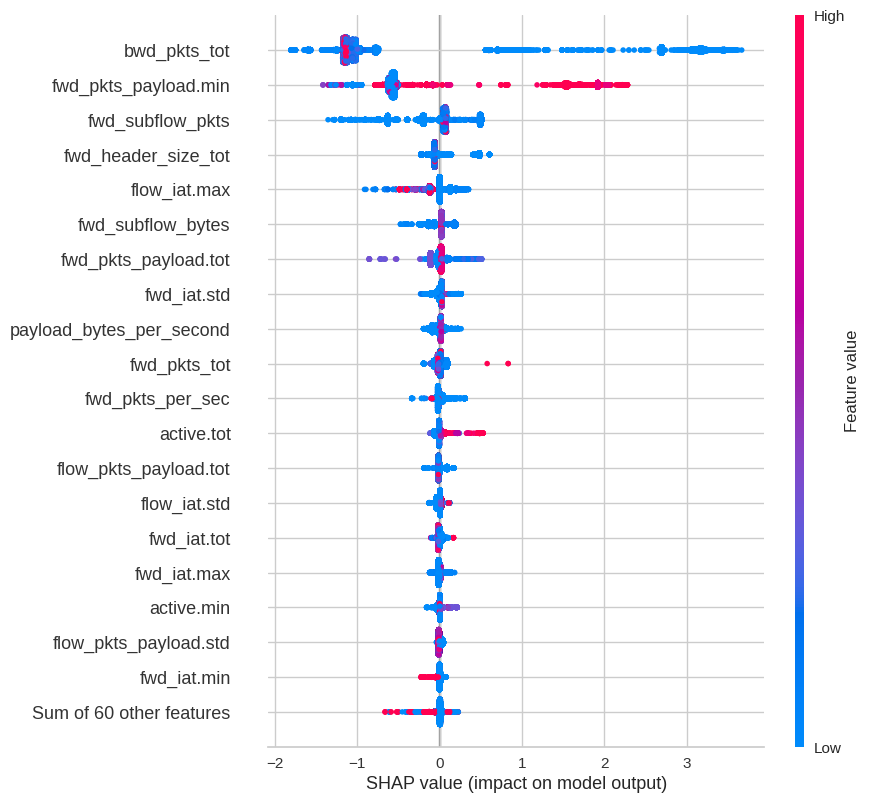

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Zero day test

In [ ]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [ ]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.901571,0.749113
1,PRECISION,0.903326,0.660275
2,RECALL,0.901571,0.749113
3,F1 SCORE,0.897142,0.697464


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


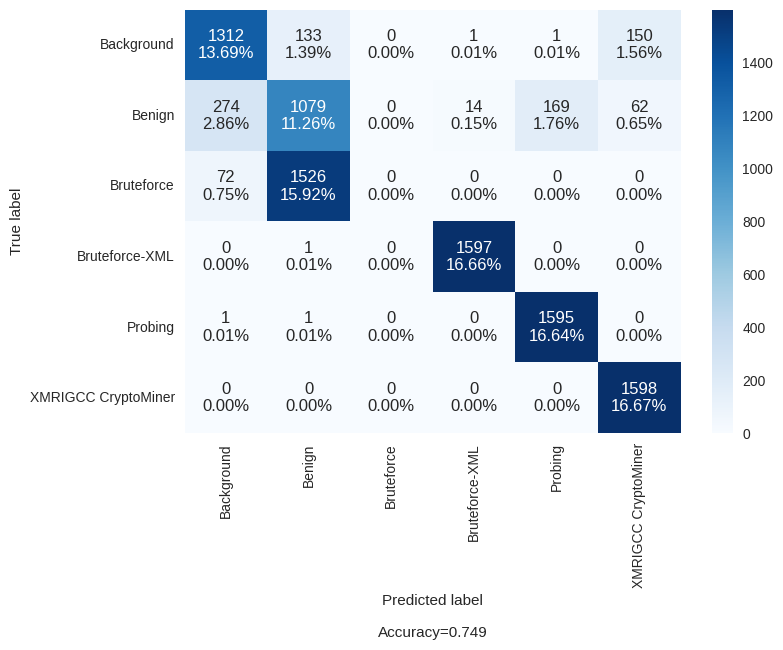

In [ ]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [ ]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce-XML']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.901446,0.747861
1,PRECISION,0.902993,0.655790
2,RECALL,0.901446,0.747861
3,F1 SCORE,0.897040,0.694859


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


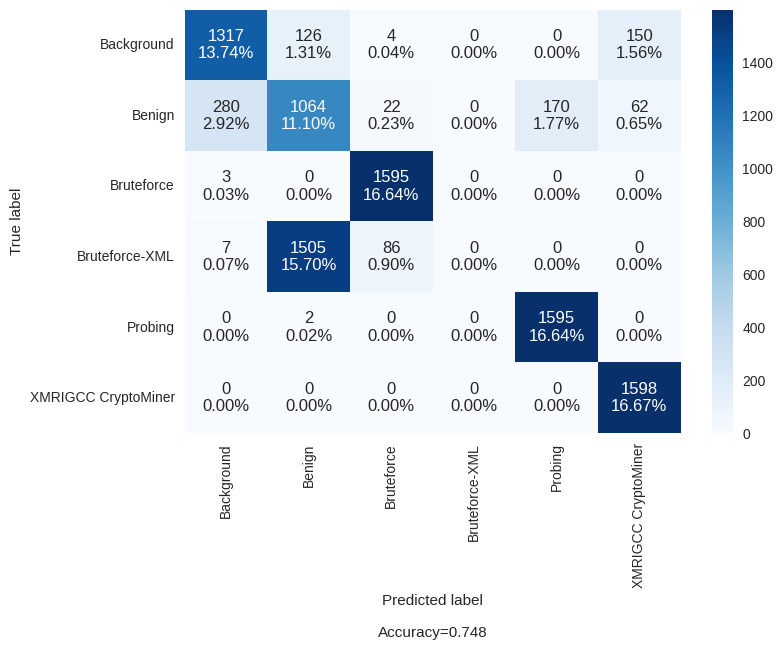

In [ ]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [ ]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Probing']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.921474,0.765283
1,PRECISION,0.922547,0.685071
2,RECALL,0.921474,0.765283
3,F1 SCORE,0.919840,0.715400


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


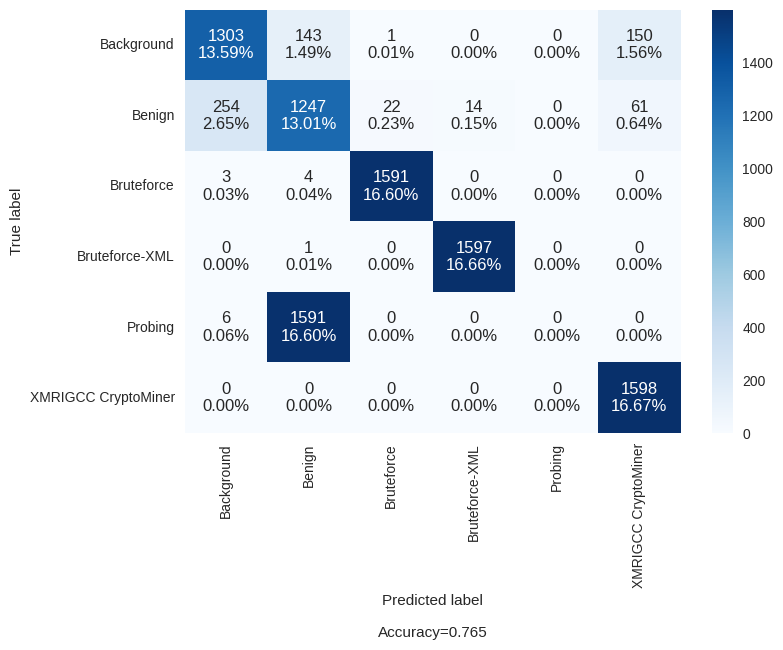

In [ ]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [ ]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'XMRIGCC CryptoMiner']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.919129,0.759441
1,PRECISION,0.922251,0.694655
2,RECALL,0.919129,0.759441
3,F1 SCORE,0.915008,0.709802


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


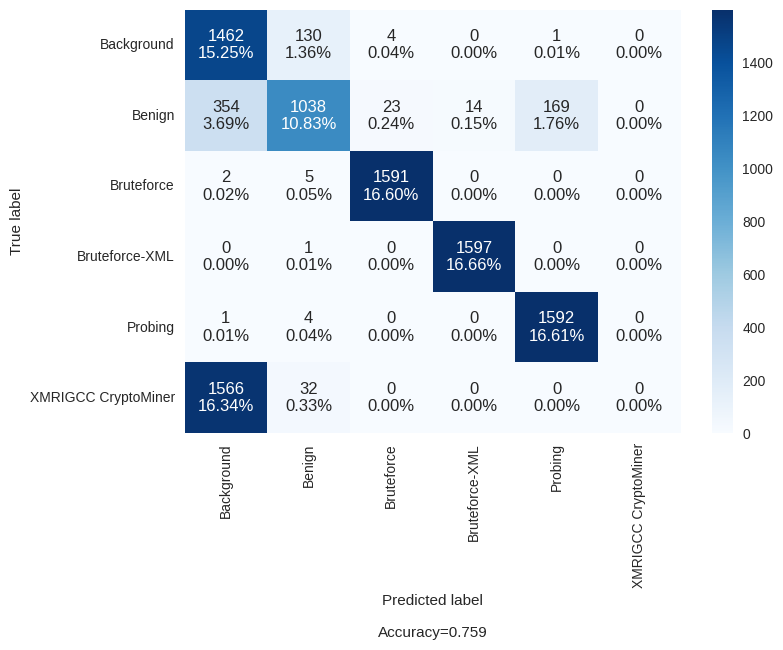

In [ ]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')